# Capacitated Vehicle Routing Problem

**Desenvolvedor**: Vítor Gabriel Reis Caitité 

In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import sqrt
import time 
from random import choice
import time
import random

## Função para cálculo da matrix de distâncias

In [2]:
# Cálculo da matrix de distâncias considerando a distância euclideana
def calculate_euc_distance_matrix(data):
    d = np.zeros((data.shape[0], data.shape[0])) # distance matrix
    for l in range(0, data.shape[0]):
        for c in range(0, data.shape[0]):
            d[l, c] = sqrt(sum((data[l] - data[c])**2))
    return d

## Nearest Neighbor

In [3]:
# Nearest neighbor for CVRP:
def nearest_neighbor(distance_matrix, demand, truck_capacity, depot = 0):
    unvisited = np.ones(distance_matrix.shape[0], dtype=bool) # to control which cities remain to visit   
    # The truck starts at the depot:
    path = [depot]    # variable to save the path
    unvisited[depot] = 0 
    cost = 0
    while np.sum(unvisited)>0:
        # First place to visit: 
        possible_starts = np.arange(0, distance_matrix.shape[0])
        start = choice(possible_starts[unvisited])
        path.append(start)  
        unvisited[start] = 0
        cost += distance_matrix[depot, path[-1]] 
        capacity = truck_capacity - demand[start]
        while capacity > 0 and np.sum(unvisited)>0:
            last_city = path[-1]
            # finding the nearest neighbor for the last city:
            next_idx = np.argmin(distance_matrix[last_city][unvisited]) 
            next_city = np.arange(distance_matrix.shape[0])[unvisited][next_idx] 
            # adding the nearest neighbor to the path if the capacity allows:
            if capacity >= demand[next_city]:
                path.append(next_city)
                unvisited[next_city] = 0
                capacity -= demand[next_city]
                # Updating the cost:
                cost += distance_matrix[last_city, next_city]
                if np.sum(unvisited)==0:
                    cost += distance_matrix[path[-1], path[0]]
                    path.append(depot)
                    break
            else:
                # restore the capacity:
                capacity = truck_capacity
                # add cost to return to depot:
                cost += distance_matrix[path[-1], path[0]]
                path.append(depot)
                break
    return path, cost

## Sweep Nearest Algorithm

In [4]:
# Cartesian coordinates to Polar:
# r = √( x^2 + y^2 )
# θ = tan-1 ( y / x )
def cart_to_pol(points, center):
    rho = np.sqrt((points[:,0]-center[0])**2 + (points[:,1]-center[1])**2)
    phi = np.arctan2((points[:,1]-center[1]), (points[:,0]-center[0]))
    return rho, (phi * 180/np.pi)%360

# Sweep Nearest Algorithm for CVRP:
def sweep_nearest(distance_matrix, demand, truck_capacity, theta, depot=0, first_idx=-1):
    sorted_idx = list(np.argsort(theta)) 
    unvisited = np.ones(distance_matrix.shape[0], dtype=bool) # to control which cities remain to visit   
    # The truck starts at the depot:
    path = [depot]    # variable to save the path
    unvisited[depot] = 0 
    cost = 0
    # initial idx (the angle of first place chosen will be the initial angle to start the sweep)
    idx = first_idx
    # random initial idx (it can be understood as choose a random angle to start the sweep)
    if idx < 0 or idx > len(theta)-1:
        idx = random.randint(0, len(theta)-1)
    while np.sum(unvisited)>0:
        # First place to visit is chosen by the sweep algorithm:
        first_place = sorted_idx[idx] 
        idx = (idx + 1) % len(theta)
        # Checking if a possible initial place was visited: 
        if unvisited[first_place] == False:
            continue
        else: 
            path.append(first_place)  
            unvisited[first_place] = 0
            cost += distance_matrix[depot, path[-1]] 
            capacity = truck_capacity - demand[first_place]
            while capacity > 0 and np.sum(unvisited)>0:
                last_city = path[-1]
                # finding the nearest neighbor for the last city:
                next_idx = np.argmin(distance_matrix[last_city][unvisited]) 
                next_city = np.arange(distance_matrix.shape[0])[unvisited][next_idx] 
                # adding the nearest neighbor to the path if the capacity allows:
                if capacity >= demand[next_city]:
                    path.append(next_city)
                    unvisited[next_city] = 0
                    capacity -= demand[next_city]
                    # Updating the cost:
                    cost += distance_matrix[last_city, next_city]
                    if np.sum(unvisited)==0:
                        cost += distance_matrix[path[-1], path[0]]
                        path.append(depot)
                        break
                else:
                    # restore the capacity:
                    capacity = truck_capacity
                    # add cost to return to depot:
                    cost += distance_matrix[path[-1], path[0]]
                    path.append(depot)
                    break
    return path, cost

## Exemplo do artigo "Sweep Nearest Algorithm for Capacitated Vehicle Routing Problem"

In [5]:
path = '~/Documents/UFMG/Mastering/3/Heurística_Meta-heurística/TPs/heuristics-and-metaheuristics/TP_Final _Article_VRPC/instances/to_test/' 
df = pd.read_csv(f'{path}E-n22-k4.vrp', skiprows=range(0, 4), sep='\s+', names=["i","X", "Y"]) 
if df["Y"].iloc[0] == "EUC_2D":
    df = df[:-4]
    truck_capacity = float(df["Y"].iloc[1])
    df1 = df[(df.index[df.i == 'DEMAND_SECTION'][0] + 1):df.shape[0]]
    demand = df1['X'].to_numpy(dtype=int)
    coord = df[3:(df.index[df.i == 'DEMAND_SECTION'][0])][["X", "Y"]].to_numpy(dtype=int)

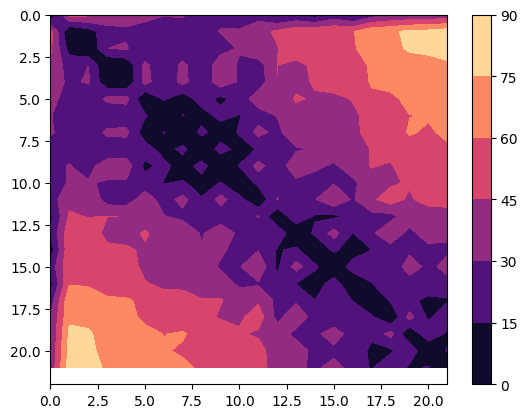

In [6]:
d = calculate_euc_distance_matrix(coord)
plt.contourf(d, cmap='magma')
plt.ylim([d.shape[0], 0])
plt.colorbar()

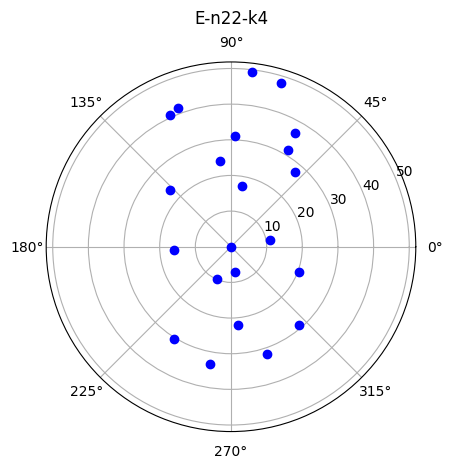

In [7]:
#for center at coord[0,:]
r, theta = cart_to_pol(coord, center=coord[0,:])

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta*np.pi/180, r, 'bo')
ax.grid(True)
ax.set_title("E-n22-k4", va='bottom')
plt.show()


In [8]:
path, cost = sweep_nearest(d, demand, truck_capacity=truck_capacity, theta=theta, depot=0, first_idx=0)
print(f'Path: {path}')
print(f'Cost: {cost}')

Path: [0, 12, 15, 18, 20, 17, 0, 9, 7, 5, 2, 1, 6, 8, 0, 10, 11, 13, 16, 14, 0, 3, 4, 19, 21, 0]
Cost: 431.6356975126727


In [9]:
path, cost = nearest_neighbor(d, demand, truck_capacity=truck_capacity, depot=0)
print(f'Path: {path}')
print(f'Cost: {cost}')

Path: [0, 16, 14, 12, 15, 18, 0, 3, 4, 6, 8, 10, 9, 7, 0, 1, 2, 5, 11, 0, 19, 21, 17, 20, 13]
Cost: 436.8814555273378


## Função para aplicação dos testes

In [14]:
def apply_test(arquives, n_tests):
    final_results = [["Arquivo", 'Nearest Neighbor', 'Sweep Nearest']]
    final_time_results = [["Arquivo", 'Nearest Neighbor', 'Sweep Nearest']]
    path = '/home/vitor/Documents/UFMG/Mastering/3/Heurística_Meta-heurística/TPs/heuristics-and-metaheuristics/TP_Final _Article_VRPC/instances/to_test/'
    for arquive in arquives:
        df = pd.read_csv(f'{path}{arquive}', skiprows=range(0, 4), sep='\s+', names=["i","X", "Y"]) 
        if df["Y"].iloc[0] == "EUC_2D":
            df = df[:-4]
            truck_capacity = float(df["Y"].iloc[1])
            df1 = df[(df.index[df.i == 'DEMAND_SECTION'][0] + 1):df.shape[0]]
            demand = df1['X'].to_numpy(dtype=float)
            coord = df[3:(df.index[df.i == 'DEMAND_SECTION'][0])][["X", "Y"]].to_numpy(dtype=float)
            _, theta = cart_to_pol(coord, center=coord[0,:])
        else:
            continue       
        distance_matrix = calculate_euc_distance_matrix(coord)
        nn_results = np.zeros(n_tests) # for nearest neighbor
        nn_time_results = np.zeros(n_tests) # for nearest neighbor
        sn_results = np.zeros(n_tests) # for sweep nearest
        sn_time_results = np.zeros(n_tests) # for sweep nearest 
        for idx in range(n_tests):
            # Nearest Neighbor:
            start_time = time.time()
            _, nn_results[idx] = nearest_neighbor(distance_matrix, demand, truck_capacity=truck_capacity, depot=0)
            end_time = time.time()
            nn_time_results[idx] = (end_time - start_time)*1000
            # Sweep Nearest:
            start_time = time.time()
            _, sn_results[idx] = sweep_nearest(distance_matrix, demand, truck_capacity=truck_capacity, theta=theta, depot=0)
            end_time = time.time()
            sn_time_results[idx] = (end_time - start_time)*1000
        result = [arquive,
                 '{:.0f}'.format(nn_results.mean()) + " +/- " + '{:.0f}'.format(nn_results.std()),
                 '{:.0f}'.format(sn_results.mean()) + " +/- " + '{:.0f}'.format(sn_results.std())]
        
        time_result = [arquive,
                      '{:.1f}'.format(nn_time_results.mean()) + " +/- " + '{:.1f}'.format(nn_time_results.std()),
                      '{:.1f}'.format(sn_time_results.mean()) + " +/- " + '{:.1f}'.format(sn_time_results.std())]    
        final_results.append(result)
        final_time_results.append(time_result)
    return final_results, final_time_results

## Resultados

In [15]:
import os
import re
import tabulate
arquives = []
path = '/home/vitor/Documents/UFMG/Mastering/3/Heurística_Meta-heurística/TPs/heuristics-and-metaheuristics/TP_Final _Article_VRPC/instances/to_test'
for root, dirs, files in os.walk(path):
    for filename in sorted(files):
        if re.search(r'.vrp', filename):
            arquives.append(filename)
results, time_results = apply_test(arquives, 20)
# Generating table results:
table1 = tabulate.tabulate(results, tablefmt='grid')
table2 = tabulate.tabulate(time_results, tablefmt='grid')

### Custo obtido por cada algoritmo em cada arquivo de teste.

In [16]:
print(table1)

+-----------------+------------------+-----------------+
| Arquivo         | Nearest Neighbor | Sweep Nearest   |
+-----------------+------------------+-----------------+
| A-n32-k5.vrp    | 978 +/- 79       | 1015 +/- 36     |
+-----------------+------------------+-----------------+
| A-n33-k5.vrp    | 814 +/- 44       | 765 +/- 21      |
+-----------------+------------------+-----------------+
| A-n34-k5.vrp    | 920 +/- 50       | 925 +/- 41      |
+-----------------+------------------+-----------------+
| A-n36-k5.vrp    | 1009 +/- 48      | 956 +/- 48      |
+-----------------+------------------+-----------------+
| A-n37-k5.vrp    | 887 +/- 62       | 886 +/- 51      |
+-----------------+------------------+-----------------+
| A-n37-k6.vrp    | 1154 +/- 69      | 1128 +/- 75     |
+-----------------+------------------+-----------------+
| A-n38-k5.vrp    | 858 +/- 77       | 888 +/- 67      |
+-----------------+------------------+-----------------+
| A-n39-k5.vrp    | 1065 +/- 95

### Tempo de execução (ms) de cada algoritmo em cada arquivo de teste. Processador i7 7th Gen., 8 Gb de RAM, sistema Linux.

In [17]:
print(table2)

+-----------------+------------------+---------------+
| Arquivo         | Nearest Neighbor | Sweep Nearest |
+-----------------+------------------+---------------+
| A-n32-k5.vrp    | 0.7 +/- 0.4      | 0.7 +/- 0.3   |
+-----------------+------------------+---------------+
| A-n33-k5.vrp    | 0.4 +/- 0.1      | 0.5 +/- 0.1   |
+-----------------+------------------+---------------+
| A-n34-k5.vrp    | 0.4 +/- 0.0      | 0.5 +/- 0.0   |
+-----------------+------------------+---------------+
| A-n36-k5.vrp    | 0.5 +/- 0.1      | 0.5 +/- 0.0   |
+-----------------+------------------+---------------+
| A-n37-k5.vrp    | 0.5 +/- 0.0      | 0.6 +/- 0.1   |
+-----------------+------------------+---------------+
| A-n37-k6.vrp    | 0.5 +/- 0.0      | 0.6 +/- 0.0   |
+-----------------+------------------+---------------+
| A-n38-k5.vrp    | 0.5 +/- 0.0      | 0.6 +/- 0.0   |
+-----------------+------------------+---------------+
| A-n39-k5.vrp    | 0.6 +/- 0.2      | 0.8 +/- 0.3   |
+---------